# Trabalho prático de dados, parte 2

<u>__Descrição__</u>: Nesta etapa do trabalho prático, o grupo precisava aplicar algum algoritmo de aprendizagem
(regras de associação, regressão, aprendizado supervisionado ou aprendizado não-supervisionado)
para classificar ou agrupar os dados e, assim, tentar prever algum acontecimento desconhecido, com
foco em evasão, nota do ENEM e CRA.

## Imports básicos

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Lendo dataset

In [241]:
df = pd.read_csv("../Datasets/dadosFiltrados.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74026 entries, 0 to 74025
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Identificador            74026 non-null  int64  
 1   Ano_Nascimento           73949 non-null  float64
 2   Sexo                     73986 non-null  object 
 3   Campus                   74026 non-null  object 
 4   Curso_Identificador      74026 non-null  int64  
 5   Curso                    74026 non-null  object 
 6   UF_Nascimento            73965 non-null  object 
 7   Municipio_Nascimento     74026 non-null  object 
 8   Admissao                 74026 non-null  object 
 9   Saida                    74026 non-null  object 
 10  Codigo_Situacao_Aluno    74026 non-null  object 
 11  Situacao_Aluno           74026 non-null  object 
 12  Situacao_Aluno_Agrupada  74026 non-null  object 
 13  Modalidade_Inscrita      68753 non-null  float64
 14  ENEM                  

### Selecionando atributos significativos

Vamos primeiramente realizar uma plotagem dos atributos do datasets para ver se conseguimos encontrar alguma correlação pelos gráficos. Para isso, foram selecionadas algumas colunas que possivelmente apresentarão resultados significativos

Como o pairplot plota valores numéricos, foi necessário converter os valores `string` para categóricos, tornando possível a plotagem dos valores

In [242]:
dfCat = df[[  # Selecionando as colunas relevantes para analise
    "Ano_Nascimento" ,
    "Sexo" ,
    "Campus" ,
    "Curso_Identificador" ,
    "UF_Nascimento" ,
    "Codigo_Situacao_Aluno" ,
    "Modalidade_Inscrita" ,
    "ENEM" ,
    "Num_Reprovacoes" ,
    "Raca" ,
    "CRA" ,
    "Area" ,
    "Admissao_Ano",
    "Saida_Ano",
]]
# Colunas não usada. As colunas abaixo foram desconsideradas ou por serem muito especificas ou por serem redundantes

# ["Identificador" , 
# "Curso" ,
# "UF_Nascimento" ,
# "Admissao" ,
# "Saida" ,
# "Situacao_Aluno" ,
# "Situacao_Aluno_Agrupada" ,
# "Admissao_Semestre",
# "Saida_Semestre"]

# Vamos converter os atributos desse dataset que são categoricos para variaveis discretas
colunas = dfCat.select_dtypes(include=['object']).columns
for col in colunas:
    dfCat[col] = dfCat[col].astype('category')
for col in colunas:
    dfCat[col] = dfCat[col].cat.codes

# Como dito na analise exploratoria, vamos remover os alunos que não se formaram ainda pois eles atrapalham a visualização
dfCat = dfCat[dfCat['Saida_Ano'] != 0]
dfCat


C:\Users\guizo\AppData\Local\Temp\ipykernel_18508\1367769737.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCat[col] = dfCat[col].astype('category')
C:\Users\guizo\AppData\Local\Temp\ipykernel_18508\1367769737.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCat[col] = dfCat[col].astype('category')
C:\Users\guizo\AppData\Local\Temp\ipykernel_18508\1367769737.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,Ano_Nascimento,Sexo,Campus,Curso_Identificador,UF_Nascimento,Codigo_Situacao_Aluno,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA,Area,Admissao_Ano,Saida_Ano
0,1982.0,1,1,1101,18,0,0.0,NaN,0,3,0.0,6,2000,2000
1,1982.0,1,1,1101,6,0,0.0,NaN,3,3,71.2,6,2000,2002
2,1979.0,0,1,1101,10,2,0.0,NaN,3,3,78.5,6,2000,2005
3,1979.0,0,1,1101,10,2,0.0,NaN,20,4,56.0,6,2000,2006
4,1980.0,0,1,1101,25,2,0.0,NaN,1,3,76.9,6,2000,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73993,2002.0,0,0,2145,7,0,9.0,602.38,5,1,4.4,4,2022,2022
73994,2002.0,1,2,3101,25,0,9.0,495.44,5,0,21.2,6,2022,2022
73999,2004.0,1,2,3102,10,0,3.0,552.52,0,1,74.2,6,2022,2022
74002,NaN,1,2,3109,10,0,9.0,550.22,5,1,2.6,3,2022,2022


In [243]:
## Plotando o pairplot

plt.figure(figsize=(17, 17))
sns.pairplot(dfCat, corner=True)
plt.savefig('Imagens/pairplot.png', format='png', dpi=300)
plt.close() # impede a impressão da figura na célula. Optamos por salvar a imagem e carregá-la no markdown

<Figure size 1700x1700 with 0 Axes>

![Imagens/pairplot.png](Imagens/pairplot.png)

### Análise do pairplot

O pairplot nos permitiu visualizar alguns padrões muito interessantes, apesar do seu tamanho e complexiddade. Justamente por isso ele foi exportado dentro do arquivo [Imagens/pairplot.png](Imagens/pairplot.png), para permitir sua visualização de forma mais detalhada. 

Para exemplificar, melhor essas relações, vamos fazer também um heatmap dos valores para medir as correlações


<Axes: >

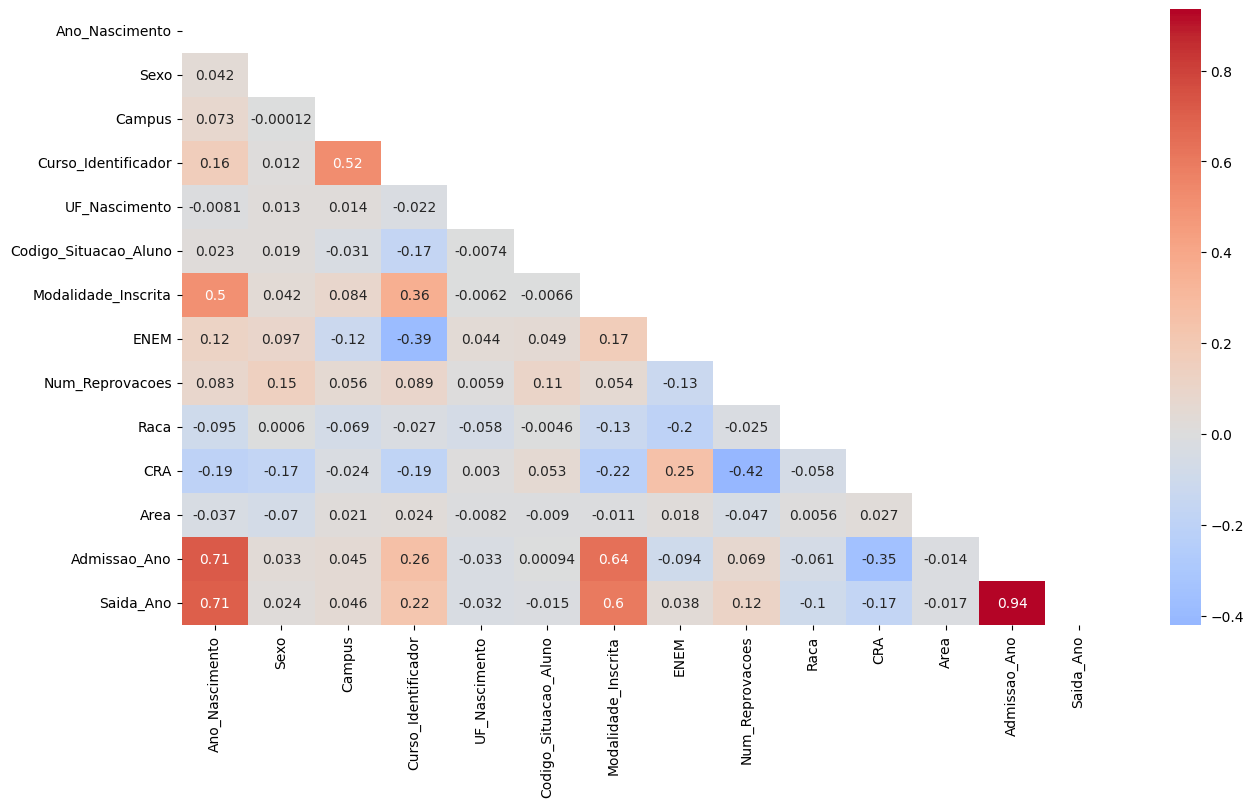

In [244]:
correlation = dfCat.corr()
matrix = np.triu(dfCat.corr())
plt.figure(figsize=(15,8))
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, center=0, cmap='coolwarm', mask=matrix)

Note que o Heatmap, em paralelo ao pairplot, são muito esclarecedores em diversos aspectos. 

É fácil perceber que as variáveis de tempo, tais como ano de saída, ano de admissão, e ano de nascimento estão fortemente interligadas. Isso pode ser facilmente esclarecido por meio do senso comum: Boa parte dos alunos ingressantes na faculdade tendem a entrar alguns anos depois de terminarem o ensino médio. O mesmo vale para a saída da faculdade, que costuma ser o tempo necessário para concluir o curso, levandoo em conta uma certa margem de erro.

Outras relações que podem ser percebidas visualmente é em relação a reprovações e sexo. Apesar do heatmap não medir essa relação muito bem, o pairplot nos mostra que existem muito poucas mulheres com alto número de reprovações (veja no paiplot que a coluna de reprovações femininas é muito menor que a masculina). Com base em tudo isso, iremos realizar algumas análises preditivas.

## Análise 1: Previsão do tempo de duração do curso

Com base nos resultados anteriores, vamos tentar prever a duração de tempo do curso com base em atributos julgados relevantes. 

Após o tratamento de dados, o dataset foi enriquecido com novas colunas. Porém para determinadas análises, certo atributos acabam sendo redundantes. Além disso, outros atributos, tais como "Indentificador" não contribuem em nada para determinação de padrões. Por conta disso, eles também foram removidos. 

Por fim, também foram desconsiderados atributos com alto grau de complexidade e de variação, tais como a cidade de nascimento e o curso dos alunos. Esses atributos, por possuirem diversos valores possíveis, acabariam por deixar a análise muito complexa


In [245]:
dfSaida = df.dropna()
dfSaida = dfSaida[dfSaida['Saida_Ano'] != 0]
dfSaida['Duracao'] = dfSaida['Saida_Ano'] - dfSaida['Admissao_Ano']
dfSaida = dfSaida[[
    "Sexo" ,
    "Campus" ,
    "Codigo_Situacao_Aluno" ,
    "Modalidade_Inscrita" ,
    "ENEM" ,
    "Num_Reprovacoes" ,
    "Raca" ,
    "CRA" ,
    "Area" ,
    "Duracao"]]

# Atributos desconsiderados
# ["Identificador" ,
# "Ano_Nascimento" ,
# "Curso" ,
# "UF_Nascimento" ,
# "Admissao" ,
# "Saida" ,
# "Situacao_Aluno" ,
# "Situacao_Aluno_Agrupada" ,
# "Curso_Identificador" ,
# "Admissao_Semestre",
# "Saida_Semestre"]

dfSaida.info()
df['Situacao_Aluno'].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 24443 entries, 24119 to 73999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sexo                   24443 non-null  object 
 1   Campus                 24443 non-null  object 
 2   Codigo_Situacao_Aluno  24443 non-null  object 
 3   Modalidade_Inscrita    24443 non-null  float64
 4   ENEM                   24443 non-null  float64
 5   Num_Reprovacoes        24443 non-null  int64  
 6   Raca                   24443 non-null  object 
 7   CRA                    24443 non-null  float64
 8   Area                   24443 non-null  object 
 9   Duracao                24443 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 2.1+ MB


array(['Abandono                                          ',
       'Conclusão                                         ',
       'Transferência                                     ',
       'Mudança de Curso                                  ',
       'Desligamento                                      ',
       'Falecimento                                       ',
       'Exclusão                                          ',
       'Habilitação                                       ',
       'Estudante em abandono de curso                    ',
       'Concluiu as exigências do curso (não colou grau)  ',
       'Normal                                            ',
       'Anulação de Matrícula                             ',
       'Concluinte (relatório não analisado)              ',
       'Matrícula Condicional/Reconsideração Desligamento ',
       'Reconsideração de Desligamento/Tramitação         ',
       'Trancamento                                       ',
       'Afastamento Espe

Na etapa acima, além da filtragem de atributos relevantes, também foi criada a coluna `Duracao`, que contém o tempo que o aluno permaneceu na faculdade.


#### Regressão com estratégia de One-Hot encoding

Para essa questão, a estratégia adotada foi a de regressão linear. Sabe-se que numa regressão, cada coluna recebe um peso (ou coeficiente) que é utilizado para calibrar a regressão. Porém os atributos categóricos acabam se tornando um problema para a regressão linear, visto que não é possível realizar uma multiplicação com um objeto ou outra variável que não seja numérica. Associar cada rótulo a uma variável discreta também seria errado, visto que uma variável aleatóriamente que recebeu um rótulo maior não seria necessáriamente mais importante (não teria uma força maior).

Para contornar esse problema, foi utilizado uma estratégia extremamente interessante conhecida como <u>__One Hot Encoding__</u>. A ideia é, para cada variável distinta de um determinado atributo, criar uma coluna que identifica se aquela variável está ou não presente naquele dado. 

Para exemplificar, imagine um dataset com uma coluna "Cor" onde os dados são classificados como "Azul", "Rosa" e "Preto". Após o OneHot, teríamos três colunas: "Cor_Azul", "Cor_Rosa" e "Cor_Preto". Um dado que originalmente era classificado como rosa terá agora valores `0,1,0` para as três colunas, respectivamente. 

In [246]:
dfOneHot = pd.get_dummies(dfSaida, columns=[
    'Sexo', 
    'Campus',
    'Codigo_Situacao_Aluno', 
    'Modalidade_Inscrita', 
    'Raca',
    'Area',
    ], drop_first=True)
x = dfOneHot.drop(columns=['Duracao'])
y = dfOneHot['Duracao']
display(dfOneHot)
x.columns

,ENEM,Num_Reprovacoes,CRA,Duracao,Sexo_M,Campus_CAV,Campus_CRP,Codigo_Situacao_Aluno_B,Codigo_Situacao_Aluno_C,Codigo_Situacao_Aluno_D,...,Area_CIENCIAS AGRARIAS,Area_CIENCIAS DA SAUDE,Area_CIENCIAS ECONOMICAS,Area_CIENCIAS EXATAS E DA TERRA,Area_CIENCIAS HUMANAS,Area_CIENCIAS SOCIAIS APLICADAS,Area_EDUCACAO,Area_ENGENHARIA,Area_INTERDISCIPLINARES,Area_LINGUISTICA LETRAS E ARTES
24119,676.98,0,67.3,0,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
24120,611.82,5,0.0,0,True,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
24121,591.10,15,28.8,1,True,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
24136,629.98,7,10.2,0,True,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
24137,628.06,2,83.0,5,True,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73964,601.72,5,0.9,0,True,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
73986,663.90,4,33.6,0,True,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
73993,602.38,5,4.4,0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
73994,495.44,5,21.2,0,True,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False


Index(['ENEM', 'Num_Reprovacoes', 'CRA', 'Sexo_M', 'Campus_CAV', 'Campus_CRP',
       'Codigo_Situacao_Aluno_B', 'Codigo_Situacao_Aluno_C',
       'Codigo_Situacao_Aluno_D', 'Codigo_Situacao_Aluno_F',
       'Codigo_Situacao_Aluno_G', 'Codigo_Situacao_Aluno_I',
       'Codigo_Situacao_Aluno_M', 'Codigo_Situacao_Aluno_N',
       'Codigo_Situacao_Aluno_Q', 'Codigo_Situacao_Aluno_S',
       'Codigo_Situacao_Aluno_T', 'Codigo_Situacao_Aluno_X',
       'Modalidade_Inscrita_1.0', 'Modalidade_Inscrita_2.0',
       'Modalidade_Inscrita_3.0', 'Modalidade_Inscrita_4.0',
       'Modalidade_Inscrita_5.0', 'Modalidade_Inscrita_6.0',
       'Modalidade_Inscrita_7.0', 'Modalidade_Inscrita_8.0',
       'Modalidade_Inscrita_9.0', 'Raca_Branco(a)', 'Raca_Indígena',
       'Raca_Informação não disponível', 'Raca_Pardo(a)', 'Raca_Preto(a)',
       'Area_CIENCIAS AGRARIAS', 'Area_CIENCIAS DA SAUDE',
       'Area_CIENCIAS ECONOMICAS', 'Area_CIENCIAS EXATAS E DA TERRA',
       'Area_CIENCIAS HUMANAS', 'Area_

Uma vez que os dados estão separados devidamente, é possível utilizar agora a regressão, atribuindo um peso diferente para cada coluna

In [247]:

lm = LinearRegression()
lm.fit(x, y)

print('Coeficiente estimado: ', lm.coef_) # Coeficientes encontrados, ou seja, qual o peso de cada atributo
print(f"\nR2 (score): {lm.score(x,y)} (Ou {(lm.score(x,y)*100):.2f}%)") # R2 Score, ou seja, quão bom é o modelo

coeff_df = pd.DataFrame(lm.coef_, x.columns, columns=['Coefficient'])
coeff_df.sort_values(by='Coefficient', ascending=False) # Atributos ordenados por ordem de importancia

Coeficiente estimado:  [ 1.06068953e-03  1.42283676e-01  2.25872441e-02  2.20249417e-02
  1.21230022e-02 -1.05176438e-01  3.30523452e+00  2.52369366e+00
 -2.36339434e-01  2.83539142e-01  1.66398178e+00  3.25048505e+00
 -4.43597036e-01  1.66000123e+00  4.73409253e+00 -4.39083504e-01
 -3.34439204e-01 -9.05598546e-01 -4.09673607e-02  4.34536953e-01
  3.71284596e-02  1.32009121e-01 -8.12802667e-02 -1.18708334e-02
 -5.71560278e-02  2.53236606e-01 -1.04788060e-01 -5.50538963e-02
  1.23553574e-02 -4.44020403e-01 -7.40766043e-02 -2.98558032e-02
  3.11200198e-02  3.20937780e-01  2.69057851e-01  1.83345204e-01
  1.99335433e-01  4.47495648e-01  2.46549382e-02  2.09665453e-01
  8.29539698e-02  4.20153634e-01]

R2 (score): 0.7242362733951555 (Ou 72.42%)


,Coefficient
Codigo_Situacao_Aluno_Q,4.734093
Codigo_Situacao_Aluno_B,3.305235
Codigo_Situacao_Aluno_I,3.250485
Codigo_Situacao_Aluno_C,2.523694
Codigo_Situacao_Aluno_G,1.663982
Codigo_Situacao_Aluno_N,1.660001
Area_CIENCIAS SOCIAIS APLICADAS,0.447496
Modalidade_Inscrita_2.0,0.434537
Area_LINGUISTICA LETRAS E ARTES,0.420154
Area_CIENCIAS DA SAUDE,0.320938


Veja que o nosso modelo teve um desemenho considerado muito bom (O valor de $R^2$ normalmente varia entre 0 e 1, sendo que em 1 ele consegue prever todos os dados com 100% de acurácia. No nosso caso, um score de 72.42% pode ser considerado um bom score). 

Quanto ao método utilizado, ele se mostrou como uma estratégia muito útil e interessante de abordagem de resolução de problemas. Além disso, esse modelo nos permite verificar um resultado muito interessante, mas que havia passado despercebido anteriormente: O atributo que mais impacta no tempo de duração do curso dos estudantes é o __Código de Situação do Aluno: Q__. Consultando novamente o [README](../README.md), o código de situação Q significa uma __"Matrícula condicional (desligamento reconsiderado)"__. 

Possivelmente esse alunos cursaram seus cursos por um período (ou talvez não chegaram a começar a cursar), foram desligados da UFV, porém posteriormente conseguiram recorrer e voltar ao curso, o que causou um tempo maior pra finalização do mesmo. Porém não é possível afirmar com certeza do que se trata o código devido a ausência de informações que o expliquem. 

Além desse atributo, diversos outros atributos interferem na duração final do curso. Confira na tabela. É interessante notar que alguns atributos que a priori pareciam os mais relevantes (tais como `num_reprovacoes`) ficaram atrás de outros que não pareciam tão relevantes.

Pode-se concluir que a geração do modelo foi um sucesso e que o modelo se mostrou muito interpretativo, ou seja, fácil de entender seus resultados e o porque de terem sido daquela forma

Veja abaixo um pequeno exemplo do modelo em funcionamento. Perceba que ele tende a dar resultados que são realmente próximos ao resultado real

In [248]:
# Usando o modelo para prever alguns dados
teste = dfOneHot[:10]
teste['Predicted'] = lm.predict(teste.drop(columns=['Duracao']))
teste[['Duracao', 'Predicted']]


C:\Users\guizo\AppData\Local\Temp\ipykernel_18508\2237762181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['Predicted'] = lm.predict(teste.drop(columns=['Duracao']))


,Duracao,Predicted
24119,0,0.570738
24120,0,0.177565
24121,1,1.603631
24136,0,0.736983
24137,5,4.166375
24194,0,-0.272257
24201,0,1.250038
24202,1,0.835472
24447,0,1.017361
24703,1,1.266756


analises possiveis:
- mulheres reprovam menos
- reprovação por campus
- enem vs reprovçoes
- cra reprovaçoes


## Analise 2: Prevendo CRA 
Para essa analise teremos que identificar os principais fatores que influenciam o coeficiente de rendimento acumulado. Para isso levaremos em consideração somente a variaveis areas e não todos os cursos em busca de uma melhor eficiência computacional. 

### Filtragem do  dados

In [249]:
dataCRA = df.copy()

### Criando variavel tempo de permanencia
Para uma analise mais efetiva iremos criar a coluna `Anos_Cursados` que irá indicar o quantos anos o aluno precisou para se formar.

In [250]:
dataCRA ['Anos_Cursados']= dataCRA['Saida_Ano'] - dataCRA['Admissao_Ano']

### Limpando DataSet

In [251]:
print(dataCRA.size)
dataCRA = dataCRA.dropna()
dataCRA.size

1776624


905256

Sabemos que no Brasil o tempo mínimo para se formar em um curso de graduação no Brasil varia de acordo diretrizes do Ministério da Educação (MEC). Sendo o menor tempo possível o de  2 anos, que é definido pelo MEC para os cursos tecnólogo, logo consideraremos apenas esse tempo para cima para analise.

In [252]:
dataCRA = dataCRA[dataCRA['Anos_Cursados'] > 1]
print(dataCRA.size)

307560


### Selecionando atributos significativos

Optamos por fazer uma limpeza considerando apenas as colunas relevantes, que não existe uma representação mais clara da mesma atravês de outras colunas ou que não limitamos a utilização anteriormente.
Desconsiderando as colunas:
 - Identificador
 - Curso_Identificador
 - Curso
 - UF_Nascimento
 - Municipio_Nascimento
 - Admissao
 - Saida
 - Situacao_Aluno
 - Situacao_Aluno_Agrupada
 - Admissao_Ano
 - Admissao_Semestre
 - Saida_Ano
 - Saida_Semestre

Feito essa filtragem dos dados para analise da relação das colunas relevantes.

In [253]:
dataCRA = dataCRA[
    ["Ano_Nascimento" ,
    "Sexo" ,
    "Campus" ,
    "Modalidade_Inscrita" ,
    "ENEM" ,
    "Num_Reprovacoes" ,
    "Raca" ,
    "CRA" ,
    "Anos_Cursados",
    "Codigo_Situacao_Aluno",
    "Area"]
]

dataCRA.head(3)

,Ano_Nascimento,Sexo,Campus,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA,Anos_Cursados,Codigo_Situacao_Aluno,Area
24137,1992.0,M,CAV,0.0,628.06,2,Branco(a),83.0,5,C,CIENCIAS EXATAS E DA TERRA
24755,1990.0,M,CAV,0.0,603.10,9,Branco(a),49.4,2,A,CIENCIAS EXATAS E DA TERRA
24810,1990.0,M,CAV,0.0,703.62,25,Pardo(a),58.9,6,M,CIENCIAS EXATAS E DA TERRA


#### Analise do comportamento das variaveis 

Para podermos visualizar o comportamento teremos que fazer uma conversão inicial somente a titulo de visualização

In [254]:
dfTeste = dataCRA.copy()

colunas = dfTeste.select_dtypes(include=['object']).columns
for col in colunas:
    dfTeste[col] = dfTeste[col].astype('category')
for col in colunas:
    dfTeste[col] = dfTeste[col].cat.codes
dfTeste.head(2)

,Ano_Nascimento,Sexo,Campus,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA,Anos_Cursados,Codigo_Situacao_Aluno,Area
24137,1992.0,1,1,0.0,628.06,2,1,83.0,5,2,4
24755,1990.0,1,1,0.0,603.10,9,1,49.4,2,0,4


#### Conferindo se há alguma relação de forte dependencia dentre as variaveis

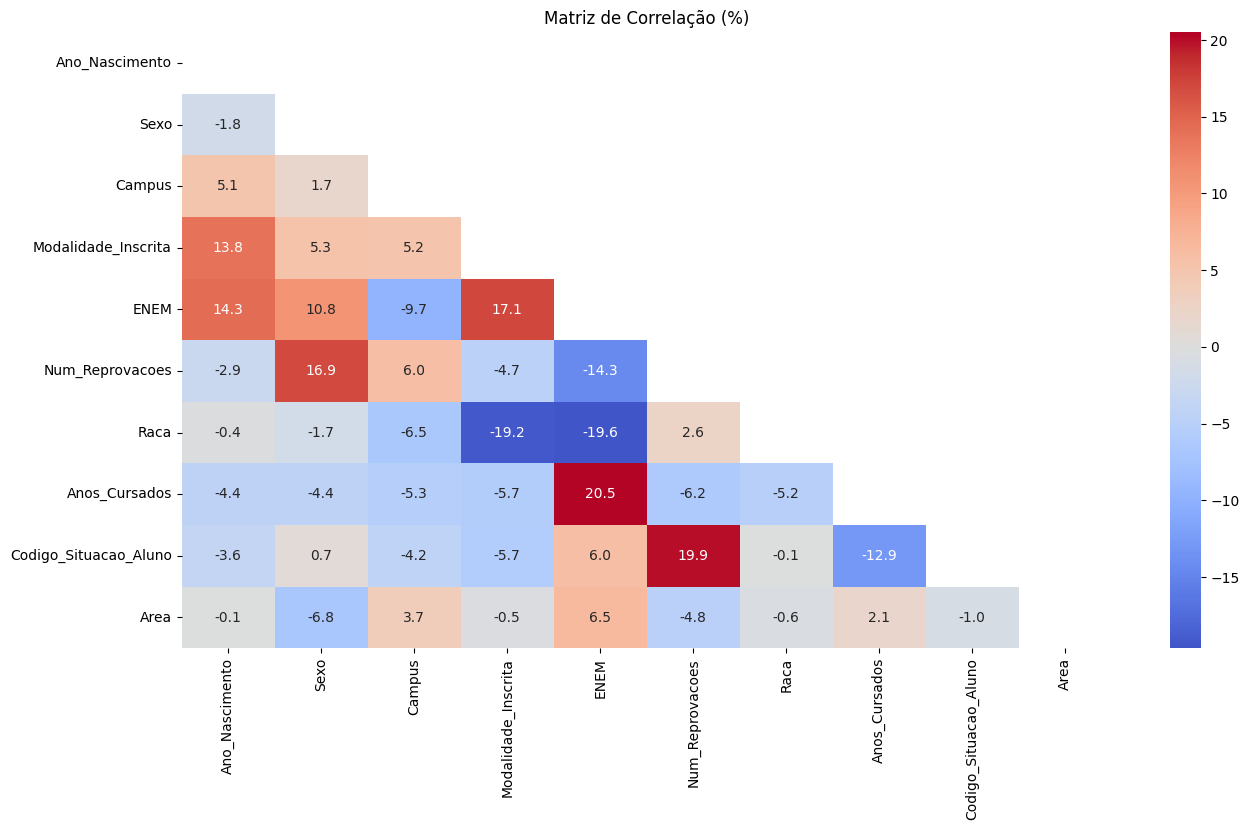

In [255]:
X = dfTeste.drop('CRA', axis=1).columns

correlation = dfTeste[X].corr()
correlation_percent = correlation * 100

# Criar a máscara para a parte superior da matriz
matrix = np.triu(correlation_percent)

plt.figure(figsize=(15,8))
sns.heatmap(correlation_percent, 
            xticklabels=correlation_percent.columns, 
            yticklabels=correlation_percent.columns, 
            annot=True, 
            fmt='.1f',  # Formatar os valores com 1 casa decimal
            center=0, 
            cmap='coolwarm', 
            mask=matrix,
            annot_kws={"size": 10})  # Ajustar o tamanho da anotação se necessário



plt.title('Matriz de Correlação (%)')
plt.show()


Observando o mapa de calor conseguimos ver que não há uma porcentagem de correlação significativa, com o maximo chegando somente a 20,5% de correlação, logo não precisaremos fazer uma limpeza nesse sentido.

### Convertendo as variaveis categoricas em numericas

In [256]:
dataCRA = pd.get_dummies(dataCRA, columns=['Modalidade_Inscrita', 'Campus', 'Raca', 'Sexo',"Codigo_Situacao_Aluno", "Area"], drop_first=True, dtype=int)
dataCRA.head(5)

,Ano_Nascimento,ENEM,Num_Reprovacoes,CRA,Anos_Cursados,Modalidade_Inscrita_1.0,Modalidade_Inscrita_2.0,Modalidade_Inscrita_3.0,Modalidade_Inscrita_4.0,Modalidade_Inscrita_5.0,...,Area_CIENCIAS AGRARIAS,Area_CIENCIAS DA SAUDE,Area_CIENCIAS ECONOMICAS,Area_CIENCIAS EXATAS E DA TERRA,Area_CIENCIAS HUMANAS,Area_CIENCIAS SOCIAIS APLICADAS,Area_EDUCACAO,Area_ENGENHARIA,Area_INTERDISCIPLINARES,Area_LINGUISTICA LETRAS E ARTES
24137,1992.0,628.06,2,83.0,5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24755,1990.0,603.10,9,49.4,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24810,1990.0,703.62,25,58.9,6,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24812,1992.0,622.88,8,39.4,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24987,1991.0,690.88,9,66.5,4,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Função acima pega cada uma das colunas e converge cada possivel valor categorico em uma coluna de zeros e uns.

### Realizando a previsão com Random Florest

In [257]:
X = dataCRA.drop('CRA', axis=1)
Y = dataCRA['CRA']
X.columns

Index(['Ano_Nascimento', 'ENEM', 'Num_Reprovacoes', 'Anos_Cursados',
       'Modalidade_Inscrita_1.0', 'Modalidade_Inscrita_2.0',
       'Modalidade_Inscrita_3.0', 'Modalidade_Inscrita_4.0',
       'Modalidade_Inscrita_5.0', 'Modalidade_Inscrita_6.0',
       'Modalidade_Inscrita_7.0', 'Modalidade_Inscrita_8.0',
       'Modalidade_Inscrita_9.0', 'Campus_CAV', 'Campus_CRP', 'Raca_Branco(a)',
       'Raca_Indígena', 'Raca_Informação não disponível', 'Raca_Pardo(a)',
       'Raca_Preto(a)', 'Sexo_M', 'Codigo_Situacao_Aluno_B',
       'Codigo_Situacao_Aluno_C', 'Codigo_Situacao_Aluno_D',
       'Codigo_Situacao_Aluno_F', 'Codigo_Situacao_Aluno_G',
       'Codigo_Situacao_Aluno_I', 'Codigo_Situacao_Aluno_M',
       'Codigo_Situacao_Aluno_N', 'Codigo_Situacao_Aluno_Q',
       'Codigo_Situacao_Aluno_S', 'Codigo_Situacao_Aluno_T',
       'Codigo_Situacao_Aluno_X', 'Area_CIENCIAS AGRARIAS',
       'Area_CIENCIAS DA SAUDE', 'Area_CIENCIAS ECONOMICAS',
       'Area_CIENCIAS EXATAS E DA TERRA', 'Ar

In [258]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [259]:
X = dataCRA.drop('CRA', axis=1)
Y = dataCRA['CRA']

In [260]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X,
        Y,
        test_size=0.3,
        random_state=0
)

In [261]:
# Criando o modelo de RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# Treinando o modelo
rf.fit(X_train, Y_train)

# Predição usando o modelo treinado
rf_Y_predicted = rf.predict(X_test)

### Observando as previsões feitas

In [262]:
df_previsoes = pd.DataFrame(X_test)
df_previsoes['CRA_Real'] = Y_test
df_previsoes['CRA_Previsto'] = rf_Y_predicted
df_previsoes['Diferenca_CRA'] = abs(df_previsoes['CRA_Real'] - df_previsoes['CRA_Previsto'])

In [263]:
df_previsoes

,Ano_Nascimento,ENEM,Num_Reprovacoes,Anos_Cursados,Modalidade_Inscrita_1.0,Modalidade_Inscrita_2.0,Modalidade_Inscrita_3.0,Modalidade_Inscrita_4.0,Modalidade_Inscrita_5.0,Modalidade_Inscrita_6.0,...,Area_CIENCIAS EXATAS E DA TERRA,Area_CIENCIAS HUMANAS,Area_CIENCIAS SOCIAIS APLICADAS,Area_EDUCACAO,Area_ENGENHARIA,Area_INTERDISCIPLINARES,Area_LINGUISTICA LETRAS E ARTES,CRA_Real,CRA_Previsto,Diferenca_CRA
57974,2000.0,655.26,7,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,50.3,54.903249,4.603249
65250,1989.0,635.92,0,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.0,82.643754,82.643754
51450,1999.0,670.70,13,3,0,0,0,0,0,0,...,0,0,0,0,1,0,0,57.0,54.657360,2.342640
54115,1997.0,534.56,20,2,0,0,0,0,0,0,...,1,0,0,0,0,0,0,43.8,36.992378,6.807622
47324,1998.0,633.92,0,5,0,0,0,0,1,0,...,0,0,0,0,0,0,0,78.1,81.124440,3.024440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45423,1997.0,584.26,4,5,0,0,0,0,1,0,...,1,0,0,0,0,0,0,73.6,74.491449,0.891449
47921,1997.0,685.34,7,5,0,0,0,0,1,0,...,0,0,0,0,1,0,0,63.0,63.845024,0.845024
49682,1992.0,697.58,6,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,19.6,52.224753,32.624753
46136,1996.0,638.12,4,2,1,0,0,0,0,0,...,0,0,0,0,1,0,0,62.2,58.402770,3.797230


### Avaliando o desempenho

In [264]:
# Avaliando o modelo
r2 = r2_score(Y_test, rf_Y_predicted)
print(f"R-squared: {r2} or {(r2*100)}%")

R-squared: 0.8205060850600636 or 82.05060850600636%


### Analise desempenho do modelo

Um valor de R-quadrado de 0,8205 significa que aproximadamente 82.05% do CRA é explicada pelo modelo de regressão. Esse valor indica que o modelo tem uma boa capacidade de previsão e ajusta bem aos dados.

### Analisando quais variaveis significativas

In [265]:
importances = rf.feature_importances_
features = X.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importances_df)

                            Feature    Importance
2                   Num_Reprovacoes  4.348351e-01
22          Codigo_Situacao_Aluno_C  3.991878e-01
3                     Anos_Cursados  3.456102e-02
1                              ENEM  3.205719e-02
0                    Ano_Nascimento  2.083586e-02
23          Codigo_Situacao_Aluno_D  1.837005e-02
27          Codigo_Situacao_Aluno_M  1.164330e-02
36  Area_CIENCIAS EXATAS E DA TERRA  8.883831e-03
33           Area_CIENCIAS AGRARIAS  4.284527e-03
20                           Sexo_M  4.207305e-03
17   Raca_Informação não disponível  2.900802e-03
13                       Campus_CAV  2.267419e-03
12          Modalidade_Inscrita_9.0  1.989349e-03
18                    Raca_Pardo(a)  1.935914e-03
8           Modalidade_Inscrita_5.0  1.806962e-03
34           Area_CIENCIAS DA SAUDE  1.675930e-03
19                    Raca_Preto(a)  1.574875e-03
5           Modalidade_Inscrita_2.0  1.560282e-03
15                   Raca_Branco(a)  1.527159e-03


Para melhorar sua eficiência e generalização iremos reduzir as variaveis para somente as quinze mais significativas.

In [266]:
# Reduzindo para as 15 variaveis mais importantes
top_features = [
    'Num_Reprovacoes',
    'Codigo_Situacao_Aluno_C',
    'Anos_Cursados',
    'ENEM',
    'Ano_Nascimento',
    'Codigo_Situacao_Aluno_D',
    'Codigo_Situacao_Aluno_M',
    'Area_CIENCIAS EXATAS E DA TERRA',
    'Area_CIENCIAS AGRARIAS',
    'Sexo_M',
    'Raca_Informação não disponível',
    'Campus_CAV',
    'Modalidade_Inscrita_9.0',
    'Raca_Pardo(a)',
    'Modalidade_Inscrita_5.0'
]


In [267]:
X_top_features = X[top_features]

# Dividindo novamente os dados
X_train_top, X_test_top, Y_train_top, Y_test_top = train_test_split(X_top_features, Y, test_size=0.2, random_state=42)

# Criando e treinando o modelo
rf_top = RandomForestRegressor(n_estimators=100, random_state=42)
rf_top.fit(X_train_top, Y_train_top)

# Predição usando o modelo treinado
rf_Y_predicted_top = rf_top.predict(X_test_top)

### Observando as previsões feitas

In [268]:
df_previsoes = pd.DataFrame(X_test_top)
df_previsoes['CRA_Real'] = Y_test_top
df_previsoes['CRA_Previsto'] = rf_Y_predicted_top
df_previsoes['Diferenca_CRA'] = abs(df_previsoes['CRA_Real'] - df_previsoes['CRA_Previsto'])

In [269]:
df_previsoes

,Num_Reprovacoes,Codigo_Situacao_Aluno_C,Anos_Cursados,ENEM,Ano_Nascimento,Codigo_Situacao_Aluno_D,Codigo_Situacao_Aluno_M,Area_CIENCIAS EXATAS E DA TERRA,Area_CIENCIAS AGRARIAS,Sexo_M,Raca_Informação não disponível,Campus_CAV,Modalidade_Inscrita_9.0,Raca_Pardo(a),Modalidade_Inscrita_5.0,CRA_Real,CRA_Previsto,Diferenca_CRA
49864,11,0,3,649.54,1992.0,0,0,0,1,1,0,0,1,1,0,47.5,52.499,4.999
52160,4,0,5,593.42,1996.0,0,0,0,0,1,0,1,0,0,0,80.6,71.505,9.095
31075,2,1,5,683.84,1992.0,0,0,0,1,1,0,1,0,0,0,75.2,74.409,0.791
45689,10,0,4,527.96,1997.0,0,0,0,0,1,0,0,1,1,0,56.8,59.770,2.970
25221,15,0,2,653.10,1991.0,0,1,1,0,1,0,1,0,0,0,38.4,46.205,7.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51388,11,0,4,550.12,1991.0,0,0,0,0,0,0,1,0,1,1,58.0,54.044,3.956
32701,2,1,5,716.60,1992.0,0,0,0,0,1,0,1,0,0,0,74.0,76.769,2.769
48547,4,1,5,613.54,1997.0,0,0,1,0,1,0,1,0,1,0,76.5,74.307,2.193
43651,2,1,6,745.14,1997.0,0,0,0,0,1,0,1,0,1,1,86.0,77.994,8.006


In [270]:
# Avaliação do modelo
r2_top = r2_score(Y_test_top, rf_Y_predicted_top)

print(f"R-squared: {r2_top} ou {(r2_top * 100):.2f}%")

R-squared: 0.8067348705083359 ou 80.67%


### Analise desempenho do modelo

O algoritmo apresentou um tempo de execução reduzido de 10,4 segundos para 5,6 segundos, o que representa uma queda de 37,5% no tempo de processamento. Essa melhoria na eficiência foi acompanhada por uma pequena perda de desempenho, com o R-squared diminuindo apenas 1,68%. Esse resultado sugere que, ao selecionar as variáveis mais relevantes, o modelo se tornou significativamente mais rápido sem comprometer substancialmente sua capacidade de explicar a variabilidade dos dados. Em resumo, a otimização resultou em um modelo mais eficiente e ágil, mantendo uma performance bastante próxima da original e com uma maior generalização.